In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm 
import math
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score
torch.manual_seed(42)
np.random.seed(42)

In [2]:
def load_datasets():
    train_set = pd.read_parquet('a_patient_triplets_processed.parquet')
    test_set = pd.read_parquet('c_patient_triplets_processed.parquet')
    return train_set, test_set

train_df, test_df = load_datasets()
train_df = train_df.dropna()
test_df = test_df.dropna()

X_train = torch.tensor(train_df.drop(columns=["In-hospital_death"]).values, dtype=torch.float32)
y_train = torch.tensor(train_df["In-hospital_death"].values, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(test_df.drop(columns=[ "In-hospital_death"]).values, dtype=torch.float32)
y_test = torch.tensor(test_df["In-hospital_death"].values, dtype=torch.float32).unsqueeze(1)

feature_columns = [col for col in train_df.columns if col not in ["RecordID", "In-hospital_death", "ICUType"]]
max_length = train_df.groupby("RecordID").size().max()

def pad_to_fixed_length(tensor, length=max_length):
    current_length = tensor.size(0)
    if current_length < length:
        padding = torch.zeros((length - current_length, tensor.size(1)))
        return torch.cat([tensor, padding], dim=0)
    else:
        return tensor

def process_dataframe(df):
    list_of_patient_tensors = []
    patient_labels = []
    grouped = df.groupby("RecordID")
    for record_id, group in grouped:
        group_tensor = torch.tensor(group[feature_columns].values, dtype=torch.float32)
        group_tensor_fixed = pad_to_fixed_length(group_tensor, length=max_length)
        list_of_patient_tensors.append(group_tensor_fixed)
        patient_labels.append(group["In-hospital_death"].max())
    sequences = torch.stack(list_of_patient_tensors, dim=0)  
    labels = torch.tensor(patient_labels, dtype=torch.float32).unsqueeze(1)
    return sequences, labels
X_train, y_train = process_dataframe(train_df)
X_test, y_test = process_dataframe(test_df)
print(X_train[0:100])

tensor([[[ 0.0000e+00,  1.0000e+01,  9.0635e-01],
         [ 0.0000e+00,  1.4000e+01, -7.8878e-01],
         [ 0.0000e+00,  2.0000e+01,  4.5319e-01],
         ...,
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]],

        [[ 0.0000e+00,  3.5000e+01, -4.7550e-03],
         [ 0.0000e+00,  2.4000e+01, -7.0948e-01],
         [ 0.0000e+00,  2.5000e+01,  2.1678e+00],
         ...,
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]],

        [[ 0.0000e+00,  1.0000e+01, -1.1070e+00],
         [ 0.0000e+00,  1.4000e+01,  6.7822e-01],
         [ 0.0000e+00,  2.0000e+01,  1.6752e+00],
         ...,
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]],

        ...,

        [[ 0.0000e+00,  3.0000e+00,  1

In [3]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=max_length):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float32) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        if d_model % 2 == 0:
            pe[:, 1::2] = torch.cos(position * div_term)
        else:
            pe[:, 1::2] = torch.cos(position * div_term)[:, :pe[:, 1::2].shape[1]]
        pe = pe.unsqueeze(0) 
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x

class TransformerClassifier(nn.Module):
    def __init__(self, input_dim=3, model_dim=64, num_heads=4, num_layers=1, num_classes=1, dropout=0.1):
        super(TransformerClassifier, self).__init__()
        self.input_linear = nn.Linear(input_dim, model_dim)
        self.positional_encoding = PositionalEncoding(d_model=model_dim, max_len=max_length)
        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.classifier = nn.Linear(model_dim, num_classes)
    
    def forward(self, x):
        x = self.input_linear(x) 
        x = self.positional_encoding(x) 
        x = x.transpose(0, 1)             
        x = self.transformer_encoder(x) 
        x = x.mean(dim=0)  
        logits = self.classifier(x) 
        
        return logits
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TransformerClassifier(input_dim=3, model_dim=64, num_heads=4, num_layers=1)
model.to(device)


criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([5])).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
batch_size = 32
num_epochs = 50
X_train = X_train.to(device)
y_train = y_train.to(device)

/cluster/courses/ml4h/jupyter/lib/python3.12/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/50: 100%|██████████| 125/125 [00:12<00:00, 10.11it/s, loss=1.22] 


Epoch 1 Loss: 1.0997


Epoch 2/50: 100%|██████████| 125/125 [00:12<00:00, 10.27it/s, loss=0.924]


Epoch 2 Loss: 1.0719


Epoch 3/50: 100%|██████████| 125/125 [00:12<00:00, 10.24it/s, loss=0.881]


Epoch 3 Loss: 1.0711


Epoch 4/50: 100%|██████████| 125/125 [00:12<00:00, 10.20it/s, loss=0.887]


Epoch 4 Loss: 1.0664


Epoch 5/50: 100%|██████████| 125/125 [00:12<00:00, 10.17it/s, loss=1.31] 


Epoch 5 Loss: 1.0635


Epoch 6/50: 100%|██████████| 125/125 [00:12<00:00, 10.10it/s, loss=1.31] 


Epoch 6 Loss: 1.0631


Epoch 7/50: 100%|██████████| 125/125 [00:12<00:00, 10.17it/s, loss=0.849]


Epoch 7 Loss: 1.0581


Epoch 8/50: 100%|██████████| 125/125 [00:12<00:00, 10.12it/s, loss=1.44] 


Epoch 8 Loss: 1.0550


Epoch 9/50: 100%|██████████| 125/125 [00:12<00:00,  9.99it/s, loss=1.15] 


Epoch 9 Loss: 1.0480


Epoch 10/50: 100%|██████████| 125/125 [00:12<00:00,  9.99it/s, loss=0.821]


Epoch 10 Loss: 1.0555


Epoch 11/50: 100%|██████████| 125/125 [00:12<00:00, 10.03it/s, loss=0.963]


Epoch 11 Loss: 1.0396


Epoch 12/50: 100%|██████████| 125/125 [00:12<00:00,  9.84it/s, loss=1.07] 


Epoch 12 Loss: 1.0522


Epoch 13/50: 100%|██████████| 125/125 [00:12<00:00,  9.91it/s, loss=1.02] 


Epoch 13 Loss: 1.0335


Epoch 14/50: 100%|██████████| 125/125 [00:12<00:00,  9.88it/s, loss=1.02] 


Epoch 14 Loss: 1.0204


Epoch 15/50: 100%|██████████| 125/125 [00:12<00:00,  9.85it/s, loss=0.806]


Epoch 15 Loss: 1.0165


Epoch 16/50: 100%|██████████| 125/125 [00:12<00:00,  9.87it/s, loss=1.1]  


Epoch 16 Loss: 1.0241


Epoch 17/50: 100%|██████████| 125/125 [00:12<00:00,  9.96it/s, loss=1.07] 


Epoch 17 Loss: 1.0238


Epoch 18/50: 100%|██████████| 125/125 [00:12<00:00, 10.07it/s, loss=1.34] 


Epoch 18 Loss: 1.0115


Epoch 19/50: 100%|██████████| 125/125 [00:12<00:00, 10.01it/s, loss=1.32] 


Epoch 19 Loss: 1.0104


Epoch 20/50: 100%|██████████| 125/125 [00:12<00:00,  9.96it/s, loss=0.934]


Epoch 20 Loss: 1.0071


Epoch 21/50: 100%|██████████| 125/125 [00:12<00:00, 10.07it/s, loss=1.1]  


Epoch 21 Loss: 0.9975


Epoch 22/50: 100%|██████████| 125/125 [00:12<00:00, 10.00it/s, loss=1.13] 


Epoch 22 Loss: 0.9980


Epoch 23/50: 100%|██████████| 125/125 [00:12<00:00,  9.94it/s, loss=0.846]


Epoch 23 Loss: 0.9962


Epoch 24/50: 100%|██████████| 125/125 [00:12<00:00,  9.99it/s, loss=0.848]


Epoch 24 Loss: 0.9862


Epoch 25/50: 100%|██████████| 125/125 [00:12<00:00, 10.00it/s, loss=1.12] 


Epoch 25 Loss: 0.9858


Epoch 26/50: 100%|██████████| 125/125 [00:12<00:00,  9.93it/s, loss=0.775]


Epoch 26 Loss: 0.9873


Epoch 27/50: 100%|██████████| 125/125 [00:12<00:00,  9.96it/s, loss=1.02] 


Epoch 27 Loss: 0.9908


Epoch 28/50: 100%|██████████| 125/125 [00:12<00:00,  9.85it/s, loss=0.952]


Epoch 28 Loss: 0.9841


Epoch 29/50: 100%|██████████| 125/125 [00:12<00:00,  9.87it/s, loss=1.69] 


Epoch 29 Loss: 0.9844


Epoch 30/50: 100%|██████████| 125/125 [00:12<00:00,  9.85it/s, loss=0.69] 


Epoch 30 Loss: 0.9759


Epoch 31/50: 100%|██████████| 125/125 [00:12<00:00,  9.84it/s, loss=0.954]


Epoch 31 Loss: 0.9782


Epoch 32/50: 100%|██████████| 125/125 [00:12<00:00,  9.86it/s, loss=1]    


Epoch 32 Loss: 0.9783


Epoch 33/50: 100%|██████████| 125/125 [00:12<00:00,  9.92it/s, loss=1.23] 


Epoch 33 Loss: 0.9830


Epoch 34/50: 100%|██████████| 125/125 [00:12<00:00,  9.79it/s, loss=0.712]


Epoch 34 Loss: 0.9802


Epoch 35/50: 100%|██████████| 125/125 [00:12<00:00,  9.96it/s, loss=0.936]


Epoch 35 Loss: 0.9712


Epoch 36/50: 100%|██████████| 125/125 [00:12<00:00, 10.06it/s, loss=1.22] 


Epoch 36 Loss: 0.9721


Epoch 37/50: 100%|██████████| 125/125 [00:12<00:00,  9.95it/s, loss=1.21] 


Epoch 37 Loss: 0.9715


Epoch 38/50: 100%|██████████| 125/125 [00:12<00:00,  9.95it/s, loss=1.48] 


Epoch 38 Loss: 0.9625


Epoch 39/50: 100%|██████████| 125/125 [00:12<00:00, 10.02it/s, loss=0.929]


Epoch 39 Loss: 0.9643


Epoch 40/50: 100%|██████████| 125/125 [00:12<00:00,  9.99it/s, loss=1.59] 


Epoch 40 Loss: 0.9726


Epoch 41/50: 100%|██████████| 125/125 [00:12<00:00,  9.94it/s, loss=1.11] 


Epoch 41 Loss: 0.9744


Epoch 42/50: 100%|██████████| 125/125 [00:12<00:00,  9.97it/s, loss=1.03] 


Epoch 42 Loss: 0.9679


Epoch 43/50: 100%|██████████| 125/125 [00:12<00:00, 10.02it/s, loss=1.05] 


Epoch 43 Loss: 0.9640


Epoch 44/50: 100%|██████████| 125/125 [00:12<00:00,  9.92it/s, loss=1.28] 


Epoch 44 Loss: 0.9590


Epoch 45/50: 100%|██████████| 125/125 [00:12<00:00,  9.94it/s, loss=0.925]


Epoch 45 Loss: 0.9581


Epoch 46/50: 100%|██████████| 125/125 [00:12<00:00,  9.94it/s, loss=0.715]


Epoch 46 Loss: 0.9557


Epoch 47/50: 100%|██████████| 125/125 [00:12<00:00, 10.03it/s, loss=1.03] 


Epoch 47 Loss: 0.9515


Epoch 48/50: 100%|██████████| 125/125 [00:12<00:00, 10.01it/s, loss=1.25] 


Epoch 48 Loss: 0.9544


Epoch 49/50: 100%|██████████| 125/125 [00:12<00:00,  9.95it/s, loss=1.19] 


Epoch 49 Loss: 0.9606


Epoch 50/50: 100%|██████████| 125/125 [00:12<00:00,  9.92it/s, loss=1.3]  


Epoch 50 Loss: 0.9528


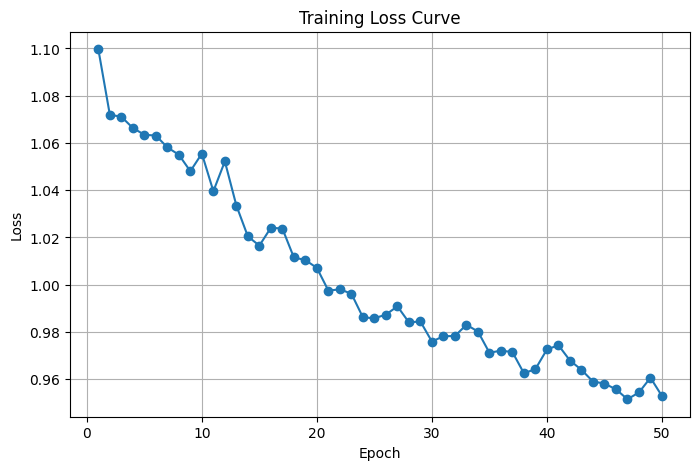

In [4]:
train_dataset = TensorDataset(X_train, y_train.float())
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# List to keep track of loss per epoch
loss_history = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for inputs, labels in progress_bar:
        inputs = inputs.to(device)  # inputs shape: (batch_size, max_length, 3)
        labels = labels.to(device)
        # If labels are of shape (batch_size,), reshape to (batch_size, 1)
        if len(labels.shape) == 1:
            labels = labels.unsqueeze(1)
        
        optimizer.zero_grad()
        # Forward pass
        logits = model(inputs)  # logits shape: (batch_size, num_classes)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        progress_bar.set_postfix(loss=loss.item())
        
    epoch_loss = running_loss / len(train_dataset)
    loss_history.append(epoch_loss)
    print(f"Epoch {epoch+1} Loss: {epoch_loss:.4f}")

# Plot the loss curve after training
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs+1), loss_history, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.grid(True)
plt.show()


In [5]:
test_dataset = TensorDataset(X_test, y_test.float())
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
def evaluate_model(model, dataloader, criterion, device):
    model.eval()  # Set model to evaluation mode
    total_loss = 0.0
    total_samples = 0
    all_probs = []
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch_data, batch_labels in tqdm(dataloader, desc="Evaluating", leave=False):
            # Move data to device
            batch_data = batch_data.to(device)
            batch_labels = batch_labels.to(device)
            
            # Forward pass
            logits = model(batch_data)
            loss = criterion(logits, batch_labels)
            
            batch_size = batch_data.size(0)
            total_loss += loss.item() * batch_size
            total_samples += batch_size
            
            # Convert logits to probabilities and then binary predictions
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).float()
            
            all_probs.append(probs.cpu())
            all_preds.append(preds.cpu())
            all_labels.append(batch_labels.cpu())
    
    # Compute average loss over all samples
    avg_loss = total_loss / total_samples
    
    # Concatenate all predictions, probabilities, and labels
    all_probs = torch.cat(all_probs, dim=0)
    all_preds = torch.cat(all_preds, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    
    # Overall accuracy
    overall_accuracy = (all_preds.eq(all_labels)).float().mean().item()
    
    # Accuracy for predicting 1 (sensitivity): among all true positives, how many were predicted as 1
    pos_idx = (all_labels == 1).squeeze()
    if pos_idx.sum() > 0:
        accuracy_pos = (all_preds[pos_idx].eq(all_labels[pos_idx])).float().mean().item()
    else:
        accuracy_pos = float('nan')
    
    # Accuracy for predicting 0 (specificity): among all true negatives, how many were predicted as 0
    neg_idx = (all_labels == 0).squeeze()
    if neg_idx.sum() > 0:
        accuracy_neg = (all_preds[neg_idx].eq(all_labels[neg_idx])).float().mean().item()
    else:
        accuracy_neg = float('nan')
    
    # Compute AUROC using probabilities (make sure to flatten the arrays)
    try:
        auroc = roc_auc_score(all_labels.numpy(), all_probs.numpy())
        auprc = average_precision_score(all_labels.numpy(), all_probs.numpy())
    except Exception as e:
        auroc = None
        print("Error computing AUROC:", e)
    
    return avg_loss, overall_accuracy, accuracy_pos, accuracy_neg, auroc, auprc

# Run evaluation on the test_loader
test_loss, overall_accuracy, accuracy_pos, accuracy_neg, test_auroc, test_auprc = evaluate_model(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}")
print(f"Overall Accuracy: {overall_accuracy*100:.2f}%")
print(f"Accuracy for predicting 1 (Sensitivity): {accuracy_pos*100:.2f}%")
print(f"Accuracy for predicting 0 (Specificity): {accuracy_neg*100:.2f}%")
print(f"AUROC: {test_auroc:.4f}")
print(f"AUPRC: {test_auprc:.4f}")
    


Test Loss: 1.0473
Overall Accuracy: 66.71%
Accuracy for predicting 1 (Sensitivity): 55.56%
Accuracy for predicting 0 (Specificity): 68.62%
AUROC: 0.6696
AUPRC: 0.2397
